### This is a practise work for one of the [MachineHack](https://www.machinehack.com/course/predict-a-doctors-consultation-fees-hackathon/) Hackathons. 
It required lot of string manipulation techniques to engineer the data before we feed into the model to predict the Doctor's consultation fees.

This tutorial doesn't cover exhaustive EDA . If you are looking for some EDA practise , Please refer to my other [kernel](https://www.kaggle.com/nitin194/nyc-taxi-trip-duration-prediction) 

In [1]:
import numpy as np 
import pandas as pd 
import unicodedata
import re
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 10

from collections import Counter

import lightgbm as lgb
import xgboost as xgb
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from catboost import Pool, CatBoostRegressor

from sklearn import metrics
from sklearn import model_selection

import gc
import time

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

This Kernel is majorly inspired from [this](https://medium.com/@supreetdeshpande95/how-to-ace-your-first-hackathon-tutorial-in-python-e40b3d0204e8) article.

In [2]:
# Read train and test dataset

train_df = pd.read_excel("../input/Final_Train.xlsx")
test_df = pd.read_excel("../input/Final_Test.xlsx")
df_test = test_df.copy()

In [3]:
train_df.head()

,Qualification,Experience,Rating,Place,Profile,Miscellaneous_Info,Fees
0,"BHMS, MD - Homeopathy",24 years experience,100%,"Kakkanad, Ernakulam",Homeopath,"100% 16 Feedback Kakkanad, Ernakulam",100
1,"BAMS, MD - Ayurveda Medicine",12 years experience,98%,"Whitefield, Bangalore",Ayurveda,"98% 76 Feedback Whitefield, Bangalore",350
2,"MBBS, MS - Otorhinolaryngology",9 years experience,NaN,"Mathikere - BEL, Bangalore",ENT Specialist,NaN,300
3,"BSc - Zoology, BAMS",12 years experience,NaN,"Bannerghatta Road, Bangalore",Ayurveda,"Bannerghatta Road, Bangalore ₹250 Available on...",250
4,BAMS,20 years experience,100%,"Keelkattalai, Chennai",Ayurveda,"100% 4 Feedback Keelkattalai, Chennai",250


In [4]:
test_df.head()

,Qualification,Experience,Rating,Place,Profile,Miscellaneous_Info
0,MBBS,35 years experience,NaN,"Ghatkopar East, Mumbai",General Medicine,NaN
1,"MBBS, Diploma in Otorhinolaryngology (DLO)",31 years experience,NaN,"West Marredpally, Hyderabad",ENT Specialist,NaN
2,"MBBS, DDVL",40 years experience,70%,"KK Nagar, Chennai",Dermatologists,"70% 4 Feedback KK Nagar, Chennai"
3,BAMS,0 years experience,NaN,"New Ashok Nagar, Delhi",Ayurveda,NaN
4,"BDS, MDS - Conservative Dentistry & Endodontics",16 years experience,100%,"Kanakpura Road, Bangalore",Dentist,General Dentistry Conservative Dentistry Cosme...


In [5]:
# Check shape of dataset

train_df.shape, test_df.shape

((5961, 7), (1987, 6))

In [6]:
# check train column types

ctype = train_df.dtypes.reset_index()
ctype.columns = ["Count", "Column Type"]
ctype.groupby("Column Type").aggregate('count').reset_index()

,Column Type,Count
0,int64,1
1,object,6


In [7]:
# check test column types

ctype = test_df.dtypes.reset_index()
ctype.columns = ["Count", "Column Type"]
ctype.groupby("Column Type").aggregate('count').reset_index()

,Column Type,Count
0,object,6


In [8]:
# Check the Maximum and Minimum number of qualifications

# Train set
dat_train = train_df.Qualification.apply(lambda x: len(x.split(',')))
print("Maximum qualifications of a doctor in the Train dataset is {}\n".format(dat_train.max()))
print("And the qualifications is --> {}\n\n".format(train_df.Qualification[dat_train.idxmax()]))
print("Minimum qualification of a doctor in the Train dataset is {}\n".format(dat_train.min()))
print("And the qualifications is --> {}\n\n".format(train_df.Qualification[dat_train.idxmin()]))

# Test set
dat_test = test_df.Qualification.apply(lambda x: len(x.split(',')))
print("Maximum qualifications of a doctor in the Test dataset is {}\n".format(dat_test.max()))
print("And the qualifications is --> {}\n\n".format(test_df.Qualification[dat_test.idxmax()]))
print("Minimum qualification of a doctor in the Test dataset is {}\n".format(dat_test.min()))
print("And the qualifications is --> {}".format(test_df.Qualification[dat_test.idxmin()]))

Maximum qualifications of a doctor in the Train dataset is 10

And the qualifications is --> Fellowship in Oral implantlogy, Certified Advance Course In Endodontics, Certified in Orthodontics, Certification in Full Mouth Rehabilitation, Certified BPS Dentist, Certificate in Cosmetic Dentistry, Professional Implantology Training Course (PITC), Fellowship in Advanced Endoscopic Sinus Surgery, Degree in Dental Implant, Fellowship in Lasers & Cosmetology


Minimum qualification of a doctor in the Train dataset is 1

And the qualifications is --> BAMS


Maximum qualifications of a doctor in the Test dataset is 17

And the qualifications is --> BDS, PG Diploma in Conservative, Endodontics and Aesthetic Dentistry, Fellowship In Clinical Cosmetology, PG Diploma In Clinical Cosmetology (PGDCC), MBA - Hospital Management, Diploma in Cosmetic Dentistry, Fellow of Academy of General Education (FAGE), Advanced Retreatment Course in RCT, Advanced Endotontic Course On Root Canal, Certified Course in 

### Lets sort and check for any unusual characters in Qualification

In [9]:
sorted(test_df.Qualification[test_df.Qualification.apply(lambda x: len(x.split(','))).idxmax()].split(","))

[' Advanced Endotontic Course On Root Canal',
 ' Advanced Retreatment Course in RCT',
 ' Certificate in Cosmetic Dentistry',
 ' Certification in Prosthodontics & Periodontology',
 ' Certified Advanced Course in Wisdom Tooth Extraction',
 ' Certified Course in Oral Surgery',
 ' Diploma in Cosmetic Dentistry',
 ' Endodontics and Aesthetic Dentistry',
 ' Fellow of Academy of General Education (FAGE)',
 ' Fellowship In Clinical Cosmetology',
 ' Fellowship in Aesthetic Dentistry (FAD)',
 ' MBA - Hospital Management',
 ' MIDA',
 ' PG Diploma In Clinical Cosmetology (PGDCC)',
 ' PG Diploma in Conservative',
 ' Post Graduate Certificate in Endodontics (PGCE)',
 'BDS']

* **We observe that qualifications are not sorted due to leading whitespace**. 
* **We also need to remove other inconsistensies in the data like**
    1. replace comma inside bracket by hyphen
    2. lowercase all the words
    3. remove spaces within qualification
* **Lets work on them and sort the variables character wise.**

In [10]:
# Define function to remove inconsistencies in the data
def sortQual(text):
    arr = re.sub(r'\([^()]+\)', lambda x: x.group().replace(",","-"), text) # to replace ',' with '-' inside brackets only
    return ','.join(sorted(arr.lower().replace(" ","").split(",")))

In [11]:
# Apply the function on the Qualification set

# Train Set
train_df.Qualification = train_df.Qualification.apply(lambda x: sortQual(x))

# Test Set
test_df.Qualification = test_df.Qualification.apply(lambda x: sortQual(x))

**Let's check and count total number of unique qualifications in Train and test set**

In [12]:
# Define a function to create a doc of all Qualifications seprataed by ','

def doc(series):
    text = ''
    for i in series:
        text += i + ','
    return text

In [13]:
# List of top 10 unique Qualifications along with there occurence in Train Set

text = doc(train_df.Qualification)
df = pd.DataFrame.from_dict(dict(Counter(text.split(',')).most_common()), orient='index').reset_index()
df.columns=['Qualification','Count']
df.head(10)

,Qualification,Count
0,mbbs,2808
1,bds,1363
2,bams,764
3,bhms,749
4,md-dermatology,606
5,ms-ent,411
6,venereology&leprosy,297
7,md-generalmedicine,285
8,diplomainotorhinolaryngology(dlo),250
9,md-homeopathy,181


In [14]:
# List of top 10 unique Qualifications along with there occurence in Test Set

text = doc(test_df.Qualification)
df = pd.DataFrame.from_dict(dict(Counter(text.split(',')).most_common()), orient='index').reset_index()
df.columns=['Qualification','Count']
df.head(10)

,Qualification,Count
0,mbbs,980
1,bds,428
2,bhms,249
3,bams,243
4,md-dermatology,196
5,ms-ent,128
6,md-generalmedicine,99
7,venereology&leprosy,91
8,diplomainotorhinolaryngology(dlo),85
9,ddvl,67


### Let's assign category codes to the unique qualifications in the test dataset.

#### We will encode qualifications only on the test data to ignore extra qualifications that are present in the train data but are not present in the test data. As the extra qualification in train data won't help model to predict fees in the test data. This is done to avoid any misfit while predicting test data after fitting on the train data due to uncommon category values.

In [15]:
text = doc(test_df.Qualification)
df = pd.DataFrame.from_dict(dict(Counter(text.split(',')).most_common()), orient='index').reset_index()
df.columns=['Qualification','Count']
df['code'] = df.Qualification.astype('category').cat.codes
df.head(10)

,Qualification,Count,code
0,mbbs,980,268
1,bds,428,14
2,bhms,249,16
3,bams,243,12
4,md-dermatology,196,286
5,ms-ent,128,354
6,md-generalmedicine,99,290
7,venereology&leprosy,91,425
8,diplomainotorhinolaryngology(dlo),85,112
9,ddvl,67,68


### Create a dictinary of Qualification with there respective codes

In [16]:
qual_dict = dict(zip(df.Qualification, df.code))

#### Define function to Separate multiple Qualifications into individual qualification columns

In [17]:
def qual_col(dataframe, col, col_num):
    return dataframe[col].str.split(',').str[col_num]

#### Split the qualifications into different columns

In [18]:
# for training set
for i in range(0,dat_train.max()):
    qual = "Qual_"+ str(i+1)
    train_df[qual] = qual_col(train_df,'Qualification', i)

    
# for test set
for i in range(0,dat_test.max()):
    qual = "Qual_"+ str(i+1)
    test_df[qual] = qual_col(test_df,'Qualification', i)


In [19]:
# Select Qualification categorical columns to be encoded

column_test = ['Qual_1', 'Qual_2', 'Qual_3', 'Qual_4',
           'Qual_5', 'Qual_6', 'Qual_7', 'Qual_8', 'Qual_9', 'Qual_10', 'Qual_11',
           'Qual_12', 'Qual_13', 'Qual_14', 'Qual_15', 'Qual_16', 'Qual_17']

column_train = ['Qual_1', 'Qual_2', 'Qual_3', 'Qual_4',
           'Qual_5', 'Qual_6', 'Qual_7', 'Qual_8', 'Qual_9', 'Qual_10']

In [20]:
# Encode categorical columns for Test and Train set

for i in column_train:
    train_df.replace({i: qual_dict}, inplace=True)
    
    
for i in column_test:
    test_df.replace({i: qual_dict}, inplace=True)

#### Let's have a look at both dataset after encoding qualification columns

In [21]:
train_df.head()

,Qualification,Experience,Rating,Place,Profile,Miscellaneous_Info,Fees,Qual_1,Qual_2,Qual_3,Qual_4,Qual_5,Qual_6,Qual_7,Qual_8,Qual_9,Qual_10
0,"bhms,md-homeopathy",24 years experience,100%,"Kakkanad, Ernakulam",Homeopath,"100% 16 Feedback Kakkanad, Ernakulam",100,16,291,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"bams,md-ayurvedamedicine",12 years experience,98%,"Whitefield, Bangalore",Ayurveda,"98% 76 Feedback Whitefield, Bangalore",350,12,280,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"mbbs,ms-otorhinolaryngology",9 years experience,NaN,"Mathikere - BEL, Bangalore",ENT Specialist,NaN,300,268,359,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"bams,bsc-zoology",12 years experience,NaN,"Bannerghatta Road, Bangalore",Ayurveda,"Bannerghatta Road, Bangalore ₹250 Available on...",250,12,21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,bams,20 years experience,100%,"Keelkattalai, Chennai",Ayurveda,"100% 4 Feedback Keelkattalai, Chennai",250,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
test_df.head()

,Qualification,Experience,Rating,Place,Profile,Miscellaneous_Info,Qual_1,Qual_2,Qual_3,Qual_4,Qual_5,Qual_6,Qual_7,Qual_8,Qual_9,Qual_10,Qual_11,Qual_12,Qual_13,Qual_14,Qual_15,Qual_16,Qual_17
0,mbbs,35 years experience,NaN,"Ghatkopar East, Mumbai",General Medicine,NaN,268,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"diplomainotorhinolaryngology(dlo),mbbs",31 years experience,NaN,"West Marredpally, Hyderabad",ENT Specialist,NaN,112,268.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"ddvl,mbbs",40 years experience,70%,"KK Nagar, Chennai",Dermatologists,"70% 4 Feedback KK Nagar, Chennai",68,268.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,bams,0 years experience,NaN,"New Ashok Nagar, Delhi",Ayurveda,NaN,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,"bds,mds-conservativedentistry&endodontics",16 years experience,100%,"Kanakpura Road, Bangalore",Dentist,General Dentistry Conservative Dentistry Cosme...,14,315.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Lets create a new column depicting the number of qualifications per doctor.

In [23]:
train_df['Qual_count'] = train_df.Qualification.apply(lambda x: len(x.split(',')))
test_df['Qual_count'] = test_df.Qualification.apply(lambda x: len(x.split(',')))

#### Now we will convert experience into integer value

In [24]:
# Train set
train_df['years_exp'] = train_df['Experience'].str.slice(stop=2).astype(int)

# Test set
test_df['years_exp'] = test_df['Experience'].str.slice(stop=2).astype(int)

In [25]:
train_df.head()

,Qualification,Experience,Rating,Place,Profile,Miscellaneous_Info,Fees,Qual_1,Qual_2,Qual_3,Qual_4,Qual_5,Qual_6,Qual_7,Qual_8,Qual_9,Qual_10,Qual_count,years_exp
0,"bhms,md-homeopathy",24 years experience,100%,"Kakkanad, Ernakulam",Homeopath,"100% 16 Feedback Kakkanad, Ernakulam",100,16,291,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,24
1,"bams,md-ayurvedamedicine",12 years experience,98%,"Whitefield, Bangalore",Ayurveda,"98% 76 Feedback Whitefield, Bangalore",350,12,280,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,12
2,"mbbs,ms-otorhinolaryngology",9 years experience,NaN,"Mathikere - BEL, Bangalore",ENT Specialist,NaN,300,268,359,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,9
3,"bams,bsc-zoology",12 years experience,NaN,"Bannerghatta Road, Bangalore",Ayurveda,"Bannerghatta Road, Bangalore ₹250 Available on...",250,12,21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,12
4,bams,20 years experience,100%,"Keelkattalai, Chennai",Ayurveda,"100% 4 Feedback Keelkattalai, Chennai",250,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,20


#### We have to fill missing ratings with NaN values as 0% and convert the string type into integer to fetch actual value

In [26]:
# Train set
train_df['Rating'].fillna('0%',inplace = True)
train_df['Rating'] = train_df['Rating'].str.slice(stop=-1).astype(int)

# Test set
test_df['Rating'].fillna('0%',inplace = True)
test_df['Rating'] = test_df['Rating'].str.slice(stop=-1).astype(int)

In [27]:
train_df.head()

,Qualification,Experience,Rating,Place,Profile,Miscellaneous_Info,Fees,Qual_1,Qual_2,Qual_3,Qual_4,Qual_5,Qual_6,Qual_7,Qual_8,Qual_9,Qual_10,Qual_count,years_exp
0,"bhms,md-homeopathy",24 years experience,100,"Kakkanad, Ernakulam",Homeopath,"100% 16 Feedback Kakkanad, Ernakulam",100,16,291,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,24
1,"bams,md-ayurvedamedicine",12 years experience,98,"Whitefield, Bangalore",Ayurveda,"98% 76 Feedback Whitefield, Bangalore",350,12,280,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,12
2,"mbbs,ms-otorhinolaryngology",9 years experience,0,"Mathikere - BEL, Bangalore",ENT Specialist,NaN,300,268,359,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,9
3,"bams,bsc-zoology",12 years experience,0,"Bannerghatta Road, Bangalore",Ayurveda,"Bannerghatta Road, Bangalore ₹250 Available on...",250,12,21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,12
4,bams,20 years experience,100,"Keelkattalai, Chennai",Ayurveda,"100% 4 Feedback Keelkattalai, Chennai",250,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,20


#### Lets cleanup inconsistencies of the **place** variable to fetch out City and localities

In [28]:
train_df.Place = train_df.Place.apply(lambda x: ','.join(str(x).lower().replace(" ","").split(",")))
test_df.Place = train_df.Place.apply(lambda x: ','.join(str(x).lower().replace(" ","").split(",")))

#### Separate City and Locality from Place variable

In [29]:
# Train Set
train_df['City'] = train_df['Place'].apply(lambda x: str(x).replace(' ','').split(',')[-1])
train_df['Locality'] = train_df['Place'].apply(lambda x: str(x).rsplit(',', 1)[0])


# Test Set
test_df['City'] = test_df['Place'].apply(lambda x: str(x).replace(' ','').split(',')[-1])
test_df['Locality'] = test_df['Place'].apply(lambda x: str(x).rsplit(',', 1)[0])

In [30]:
# Lets Check Unique Cities in test set

test_df.City.value_counts()

delhi                 406
bangalore             403
mumbai                401
hyderabad             319
chennai               290
coimbatore             78
ernakulam              52
thiruvananthapuram     30
nan                     8
Name: City, dtype: int64

In [31]:
# Lets Check Unique Cities in train set

train_df.City.value_counts()

bangalore             1258
mumbai                1219
delhi                 1185
hyderabad              951
chennai                855
coimbatore             228
ernakulam              153
thiruvananthapuram      86
nan                     25
e                        1
Name: City, dtype: int64

#### Let's check that final record with **e** as the city name

In [32]:
train_df[train_df.City == 'e']

,Qualification,Experience,Rating,Place,Profile,Miscellaneous_Info,Fees,Qual_1,Qual_2,Qual_3,Qual_4,Qual_5,Qual_6,Qual_7,Qual_8,Qual_9,Qual_10,Qual_count,years_exp,City,Locality
3980,bds,23 years experience,0,e,Dentist,NaN,250,14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,23,e,e


#### Clearly its a one off record. Lets mark the Place, city and locality as missing instead of deleting the record.

In [33]:
train_df.loc[3980, 'Place'] = np.nan
train_df.loc[3980, 'City'] = np.nan
train_df.loc[3980, 'Locality'] = np.nan

#### Since the number of Cities are less, We can dummify the city names. Lets do it

In [34]:
# Define function to dummify feature

def get_dummies(dataframe,feature_name):
  dummy = pd.get_dummies(dataframe[feature_name], prefix=feature_name)
  dummy.drop(dummy.columns[0], axis=1, inplace=True) #avoid dummy trap
  return pd.concat([dataframe,dummy], axis = 1)

In [35]:
train_df = get_dummies(train_df, 'City')
test_df = get_dummies(test_df, 'City')

In [36]:
# Checkout dataframe after dummification of City

train_df.head()

,Qualification,Experience,Rating,Place,Profile,Miscellaneous_Info,Fees,Qual_1,Qual_2,Qual_3,Qual_4,Qual_5,Qual_6,Qual_7,Qual_8,Qual_9,Qual_10,Qual_count,years_exp,City,Locality,City_chennai,City_coimbatore,City_delhi,City_ernakulam,City_hyderabad,City_mumbai,City_nan,City_thiruvananthapuram
0,"bhms,md-homeopathy",24 years experience,100,"kakkanad,ernakulam",Homeopath,"100% 16 Feedback Kakkanad, Ernakulam",100,16,291,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,24,ernakulam,kakkanad,0,0,0,1,0,0,0,0
1,"bams,md-ayurvedamedicine",12 years experience,98,"whitefield,bangalore",Ayurveda,"98% 76 Feedback Whitefield, Bangalore",350,12,280,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,12,bangalore,whitefield,0,0,0,0,0,0,0,0
2,"mbbs,ms-otorhinolaryngology",9 years experience,0,"mathikere-bel,bangalore",ENT Specialist,NaN,300,268,359,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,9,bangalore,mathikere-bel,0,0,0,0,0,0,0,0
3,"bams,bsc-zoology",12 years experience,0,"bannerghattaroad,bangalore",Ayurveda,"Bannerghatta Road, Bangalore ₹250 Available on...",250,12,21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,12,bangalore,bannerghattaroad,0,0,0,0,0,0,0,0
4,bams,20 years experience,100,"keelkattalai,chennai",Ayurveda,"100% 4 Feedback Keelkattalai, Chennai",250,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,20,chennai,keelkattalai,1,0,0,0,0,0,0,0


#### Let's now check the unique Profile's in the dataset

In [37]:
train_df.Profile.value_counts()

Dentist             1397
General Medicine    1173
Dermatologists      1034
Homeopath            843
Ayurveda             786
ENT Specialist       728
Name: Profile, dtype: int64

Let's prune up the profile variable and dummify them in both the datasets

In [38]:
train_df.Profile = train_df.Profile.apply(lambda x: str(x).lower().replace(" ",""))
test_df.Profile = train_df.Profile.apply(lambda x: str(x).lower().replace(" ",""))

In [39]:
train_df = get_dummies(train_df, 'Profile')
test_df = get_dummies(test_df, 'Profile')

#### Let's checkout the dataset after dummification of profile variable

In [40]:
train_df.head()

,Qualification,Experience,Rating,Place,Profile,Miscellaneous_Info,Fees,Qual_1,Qual_2,Qual_3,Qual_4,Qual_5,Qual_6,Qual_7,Qual_8,Qual_9,Qual_10,Qual_count,years_exp,City,Locality,City_chennai,City_coimbatore,City_delhi,City_ernakulam,City_hyderabad,City_mumbai,City_nan,City_thiruvananthapuram,Profile_dentist,Profile_dermatologists,Profile_entspecialist,Profile_generalmedicine,Profile_homeopath
0,"bhms,md-homeopathy",24 years experience,100,"kakkanad,ernakulam",homeopath,"100% 16 Feedback Kakkanad, Ernakulam",100,16,291,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,24,ernakulam,kakkanad,0,0,0,1,0,0,0,0,0,0,0,0,1
1,"bams,md-ayurvedamedicine",12 years experience,98,"whitefield,bangalore",ayurveda,"98% 76 Feedback Whitefield, Bangalore",350,12,280,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,12,bangalore,whitefield,0,0,0,0,0,0,0,0,0,0,0,0,0
2,"mbbs,ms-otorhinolaryngology",9 years experience,0,"mathikere-bel,bangalore",entspecialist,NaN,300,268,359,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,9,bangalore,mathikere-bel,0,0,0,0,0,0,0,0,0,0,1,0,0
3,"bams,bsc-zoology",12 years experience,0,"bannerghattaroad,bangalore",ayurveda,"Bannerghatta Road, Bangalore ₹250 Available on...",250,12,21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,12,bangalore,bannerghattaroad,0,0,0,0,0,0,0,0,0,0,0,0,0
4,bams,20 years experience,100,"keelkattalai,chennai",ayurveda,"100% 4 Feedback Keelkattalai, Chennai",250,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,20,chennai,keelkattalai,1,0,0,0,0,0,0,0,0,0,0,0,0


In [41]:
# train_df.Locality.value_counts()

In [42]:
# List of top 10 Localities along with there occurence in Train Set
train_df['Locality'] = train_df['Locality'].apply(str) # Convert int64 dtype to str type first
text = doc(train_df.Locality)
df = pd.DataFrame.from_dict(dict(Counter(text.split(',')).most_common()), orient='index').reset_index()
df.columns=['Locality','Count']
df.head(10)

,Locality,Count
0,hsrlayout,75
1,andheriwest,70
2,dwarka,68
3,banjarahills,64
4,mulundwest,54
5,borivaliwest,52
6,kandivaliwest,50
7,indiranagar,48
8,whitefield,47
9,malleswaram,47


In [43]:
# List of top 10 unique Localities along with there occurence in Test Set
test_df['Locality'] = test_df['Locality'].apply(str) # Convert int64 dtype to str type first
text = doc(test_df.Locality)
df = pd.DataFrame.from_dict(dict(Counter(text.split(',')).most_common()), orient='index').reset_index()
df.columns=['Locality','Count']
df.head(10)

,Locality,Count
0,andheriwest,25
1,borivaliwest,23
2,dwarka,23
3,malleswaram,21
4,hsrlayout,20
5,ghatkopareast,20
6,whitefield,19
7,indiranagar,19
8,kandivaliwest,18
9,adyar,16


#### Let's encode Locality feature of the test set and then merge into train set

In [44]:
# Define function to label encode the selected categorical variable for modeling

def encode(data):
    return data.astype('category').cat.codes

In [45]:
# Encode Locality column of test data

columns = ['Locality']

for i in columns:
    col = i+"_code"
    test_df[col] = encode(test_df[i])

In [46]:
# Check test dataset after encoding locality
test_df.head()

,Qualification,Experience,Rating,Place,Profile,Miscellaneous_Info,Qual_1,Qual_2,Qual_3,Qual_4,Qual_5,Qual_6,Qual_7,Qual_8,Qual_9,Qual_10,Qual_11,Qual_12,Qual_13,Qual_14,Qual_15,Qual_16,Qual_17,Qual_count,years_exp,City,Locality,City_chennai,City_coimbatore,City_delhi,City_ernakulam,City_hyderabad,City_mumbai,City_nan,City_thiruvananthapuram,Profile_dentist,Profile_dermatologists,Profile_entspecialist,Profile_generalmedicine,Profile_homeopath,Locality_code
0,mbbs,35 years experience,0,"kakkanad,ernakulam",homeopath,NaN,268,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,35,ernakulam,kakkanad,0,0,0,1,0,0,0,0,0,0,0,0,1,207
1,"diplomainotorhinolaryngology(dlo),mbbs",31 years experience,0,"whitefield,bangalore",ayurveda,NaN,112,268.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,31,bangalore,whitefield,0,0,0,0,0,0,0,0,0,0,0,0,0,587
2,"ddvl,mbbs",40 years experience,70,"mathikere-bel,bangalore",entspecialist,"70% 4 Feedback KK Nagar, Chennai",68,268.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,40,bangalore,mathikere-bel,0,0,0,0,0,0,0,0,0,0,1,0,0,308
3,bams,0 years experience,0,"bannerghattaroad,bangalore",ayurveda,NaN,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,bangalore,bannerghattaroad,0,0,0,0,0,0,0,0,0,0,0,0,0,50
4,"bds,mds-conservativedentistry&endodontics",16 years experience,100,"keelkattalai,chennai",ayurveda,General Dentistry Conservative Dentistry Cosme...,14,315.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,16,chennai,keelkattalai,1,0,0,0,0,0,0,0,0,0,0,0,0,234


In [47]:
# Create unique lists of [variable, variable code] combination and drop duplicate pairs.

df_test_merge = test_df[['Locality','Locality_code']].drop_duplicates()

In [48]:
# Pull the respective encoded variables list in the train data (Using a left join) to avoid any merging issue.

train_df = pd.merge(train_df,df_test_merge[['Locality','Locality_code']],on='Locality', how='left')

In [49]:
# Train set after merging encoded Locality

train_df.head()

,Qualification,Experience,Rating,Place,Profile,Miscellaneous_Info,Fees,Qual_1,Qual_2,Qual_3,Qual_4,Qual_5,Qual_6,Qual_7,Qual_8,Qual_9,Qual_10,Qual_count,years_exp,City,Locality,City_chennai,City_coimbatore,City_delhi,City_ernakulam,City_hyderabad,City_mumbai,City_nan,City_thiruvananthapuram,Profile_dentist,Profile_dermatologists,Profile_entspecialist,Profile_generalmedicine,Profile_homeopath,Locality_code
0,"bhms,md-homeopathy",24 years experience,100,"kakkanad,ernakulam",homeopath,"100% 16 Feedback Kakkanad, Ernakulam",100,16,291,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,24,ernakulam,kakkanad,0,0,0,1,0,0,0,0,0,0,0,0,1,207.0
1,"bams,md-ayurvedamedicine",12 years experience,98,"whitefield,bangalore",ayurveda,"98% 76 Feedback Whitefield, Bangalore",350,12,280,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,12,bangalore,whitefield,0,0,0,0,0,0,0,0,0,0,0,0,0,587.0
2,"mbbs,ms-otorhinolaryngology",9 years experience,0,"mathikere-bel,bangalore",entspecialist,NaN,300,268,359,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,9,bangalore,mathikere-bel,0,0,0,0,0,0,0,0,0,0,1,0,0,308.0
3,"bams,bsc-zoology",12 years experience,0,"bannerghattaroad,bangalore",ayurveda,"Bannerghatta Road, Bangalore ₹250 Available on...",250,12,21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,12,bangalore,bannerghattaroad,0,0,0,0,0,0,0,0,0,0,0,0,0,50.0
4,bams,20 years experience,100,"keelkattalai,chennai",ayurveda,"100% 4 Feedback Keelkattalai, Chennai",250,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,20,chennai,keelkattalai,1,0,0,0,0,0,0,0,0,0,0,0,0,234.0


#### Coming to the messy column i.e Miscellaneous_Info Lets make the most out of this.

In [50]:
list(train_df.Miscellaneous_Info[0:10])

['100% 16 Feedback Kakkanad, Ernakulam',
 '98% 76 Feedback Whitefield, Bangalore',
 nan,
 'Bannerghatta Road, Bangalore ₹250 Available on Sun, 10 Feb',
 '100% 4 Feedback Keelkattalai, Chennai',
 nan,
 nan,
 'Dental Fillings Crowns and Bridges Fixing Impaction / Impacted Tooth Extraction',
 nan,
 nan]

**It can be observed that:**

1. Few rows have NaN values
1. Few rows give only the profile related info along with the fees of the Doctor ;)
1. Other rows give info about the doctors rating followed by number of people rated then the address
1. There are lot of commas in the value, Lets remove them to avoid any discrepancy

In [51]:
train_df.Miscellaneous_Info = train_df.Miscellaneous_Info.str.replace(",","")
test_df.Miscellaneous_Info = test_df.Miscellaneous_Info.str.replace(",","")

### Now let's convert the Indian Rupee symbol to readable INR String

In [52]:
# Train set
train_df.Miscellaneous_Info = train_df.Miscellaneous_Info.str.replace(unicodedata.lookup('Indian Rupee Sign'), 'INR ')

# Test set
test_df.Miscellaneous_Info = test_df.Miscellaneous_Info.str.replace(unicodedata.lookup('Indian Rupee Sign'), 'INR ')

In [53]:
list(train_df.Miscellaneous_Info[0:10])

['100% 16 Feedback Kakkanad Ernakulam',
 '98% 76 Feedback Whitefield Bangalore',
 nan,
 'Bannerghatta Road Bangalore INR 250 Available on Sun 10 Feb',
 '100% 4 Feedback Keelkattalai Chennai',
 nan,
 nan,
 'Dental Fillings Crowns and Bridges Fixing Impaction / Impacted Tooth Extraction',
 nan,
 nan]

In [54]:
# Define function to return the Feedback numbers

def find_feedback(data):
    result = re.search(r' (.*?) Feedback',data)
    if result:
        return int(result.group(1))
    else:
        return 0

In [55]:
# Fetch out the feedback numbers in different records. 

# Train set
train_df['feedack_num'] = train_df.Miscellaneous_Info.apply(lambda x: find_feedback(x) if '%' in str(x) else 0)

# Test set
test_df['feedack_num'] = test_df.Miscellaneous_Info.apply(lambda x: find_feedback(x) if '%' in str(x) else 0)

In [56]:
train_df.head()

,Qualification,Experience,Rating,Place,Profile,Miscellaneous_Info,Fees,Qual_1,Qual_2,Qual_3,Qual_4,Qual_5,Qual_6,Qual_7,Qual_8,Qual_9,Qual_10,Qual_count,years_exp,City,Locality,City_chennai,City_coimbatore,City_delhi,City_ernakulam,City_hyderabad,City_mumbai,City_nan,City_thiruvananthapuram,Profile_dentist,Profile_dermatologists,Profile_entspecialist,Profile_generalmedicine,Profile_homeopath,Locality_code,feedack_num
0,"bhms,md-homeopathy",24 years experience,100,"kakkanad,ernakulam",homeopath,100% 16 Feedback Kakkanad Ernakulam,100,16,291,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,24,ernakulam,kakkanad,0,0,0,1,0,0,0,0,0,0,0,0,1,207.0,16
1,"bams,md-ayurvedamedicine",12 years experience,98,"whitefield,bangalore",ayurveda,98% 76 Feedback Whitefield Bangalore,350,12,280,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,12,bangalore,whitefield,0,0,0,0,0,0,0,0,0,0,0,0,0,587.0,76
2,"mbbs,ms-otorhinolaryngology",9 years experience,0,"mathikere-bel,bangalore",entspecialist,NaN,300,268,359,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,9,bangalore,mathikere-bel,0,0,0,0,0,0,0,0,0,0,1,0,0,308.0,0
3,"bams,bsc-zoology",12 years experience,0,"bannerghattaroad,bangalore",ayurveda,Bannerghatta Road Bangalore INR 250 Available ...,250,12,21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,12,bangalore,bannerghattaroad,0,0,0,0,0,0,0,0,0,0,0,0,0,50.0,0
4,bams,20 years experience,100,"keelkattalai,chennai",ayurveda,100% 4 Feedback Keelkattalai Chennai,250,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,20,chennai,keelkattalai,1,0,0,0,0,0,0,0,0,0,0,0,0,234.0,4


In [57]:
# Let us have a look at the different Fee value in the records.

list(train_df.Miscellaneous_Info[train_df.Miscellaneous_Info.str.contains('INR', na = False)].sample(10))

['3 Feedback Kothaguda Hyderabad INR 500',
 'Vileparle West Mumbai INR 800 Available Today',
 'Royapettah Chennai INR 300 Available Today',
 'Rajouri Garden Delhi INR 250 Visits Today',
 '24 Feedback Banashankari 3rd Stage Bangalore INR 250',
 '1 Feedback Janak Puri Delhi INR 300',
 'Malad West Mumbai INR 800 Visits on Fri 08 Feb',
 '2 Feedback Indiranagar Bangalore INR 500',
 '1 Feedback Goldwins Coimbatore INR 100',
 '1 Feedback Karol Bagh Delhi INR 500']

* It is observed that the Fees value is not consistent as some records contains more than one fee value.
* It is also observed that the second fee value is just 120% value of the first fee value. 
* So we will take only the first fee value wherever available.

In [58]:
# Define function to return the Fees Value

def find_fees(data):
    result = re.search(r'INR (\d*)',data)
    if result:
        return int(result.group(1))
    else:
        return 0


In [59]:
# Fetch out the Fees value in different records. 

# Train set
train_df['fees_val'] = train_df.Miscellaneous_Info.apply(lambda x: find_fees(x) if 'INR' in str(x) else 0)

# Test set
test_df['fees_val'] = test_df.Miscellaneous_Info.apply(lambda x: find_fees(x) if 'INR' in str(x) else 0)

In [60]:
train_df.head()

,Qualification,Experience,Rating,Place,Profile,Miscellaneous_Info,Fees,Qual_1,Qual_2,Qual_3,Qual_4,Qual_5,Qual_6,Qual_7,Qual_8,Qual_9,Qual_10,Qual_count,years_exp,City,Locality,City_chennai,City_coimbatore,City_delhi,City_ernakulam,City_hyderabad,City_mumbai,City_nan,City_thiruvananthapuram,Profile_dentist,Profile_dermatologists,Profile_entspecialist,Profile_generalmedicine,Profile_homeopath,Locality_code,feedack_num,fees_val
0,"bhms,md-homeopathy",24 years experience,100,"kakkanad,ernakulam",homeopath,100% 16 Feedback Kakkanad Ernakulam,100,16,291,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,24,ernakulam,kakkanad,0,0,0,1,0,0,0,0,0,0,0,0,1,207.0,16,0
1,"bams,md-ayurvedamedicine",12 years experience,98,"whitefield,bangalore",ayurveda,98% 76 Feedback Whitefield Bangalore,350,12,280,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,12,bangalore,whitefield,0,0,0,0,0,0,0,0,0,0,0,0,0,587.0,76,0
2,"mbbs,ms-otorhinolaryngology",9 years experience,0,"mathikere-bel,bangalore",entspecialist,NaN,300,268,359,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,9,bangalore,mathikere-bel,0,0,0,0,0,0,0,0,0,0,1,0,0,308.0,0,0
3,"bams,bsc-zoology",12 years experience,0,"bannerghattaroad,bangalore",ayurveda,Bannerghatta Road Bangalore INR 250 Available ...,250,12,21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,12,bangalore,bannerghattaroad,0,0,0,0,0,0,0,0,0,0,0,0,0,50.0,0,250
4,bams,20 years experience,100,"keelkattalai,chennai",ayurveda,100% 4 Feedback Keelkattalai Chennai,250,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,20,chennai,keelkattalai,1,0,0,0,0,0,0,0,0,0,0,0,0,234.0,4,0


#### Let's check the Fees Distribution in Train Dataset

In [61]:
train_df.Fees.value_counts().reset_index().sort_values(by='index')

,index,Fees
30,5,1
21,10,2
39,20,1
20,30,4
25,40,2
11,50,81
19,60,11
17,70,18
18,80,12
0,100,1306


It is observable that many records have Fees mentioned as less than 50. Lets check those records.

In [62]:
train_df[train_df.Fees < 50]

,Qualification,Experience,Rating,Place,Profile,Miscellaneous_Info,Fees,Qual_1,Qual_2,Qual_3,Qual_4,Qual_5,Qual_6,Qual_7,Qual_8,Qual_9,Qual_10,Qual_count,years_exp,City,Locality,City_chennai,City_coimbatore,City_delhi,City_ernakulam,City_hyderabad,City_mumbai,City_nan,City_thiruvananthapuram,Profile_dentist,Profile_dermatologists,Profile_entspecialist,Profile_generalmedicine,Profile_homeopath,Locality_code,feedack_num,fees_val
1316,bams,4 years experience,0,"worli,mumbai",ayurveda,NaN,10,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,4,mumbai,worli,0,0,0,0,0,1,0,0,0,0,0,0,0,589.0,0,0
1930,bds,6 years experience,0,"tvmedicalcollege,thiruvananthapuram",dentist,NaN,5,14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,6,thiruvananthapuram,tvmedicalcollege,0,0,0,0,0,0,0,1,1,0,0,0,0,538.0,0,0
2248,"bhms,certificateinchildhealth(cch),cgo",22 years experience,0,"kandivaliwest,mumbai",homeopath,NaN,40,16,34,58,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,22,mumbai,kandivaliwest,0,0,0,0,0,1,0,0,0,0,0,0,1,221.0,0,0
2459,bams,37 years experience,0,"bandraeast,mumbai",ayurveda,NaN,40,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,37,mumbai,bandraeast,0,0,0,0,0,1,0,0,0,0,0,0,0,46.0,0,0
2563,md-ayurvedamedicine,35 years experience,0,"marathahalli,bangalore",ayurveda,NaN,30,280,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,35,bangalore,marathahalli,0,0,0,0,0,0,0,0,0,0,0,0,0,306.0,0,0
3303,bds,3 years experience,0,"perumbavoor,ernakulam",dentist,NaN,10,14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,3,ernakulam,perumbavoor,0,0,0,1,0,0,0,0,1,0,0,0,0,407.0,0,0
3499,bams,45 years experience,0,"bhandupwest,mumbai",ayurveda,NaN,30,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,45,mumbai,bhandupwest,0,0,0,0,0,1,0,0,0,0,0,0,0,61.0,0,0
4290,bams,15 years experience,0,"secunderabad,hyderabad",ayurveda,NaN,30,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,15,hyderabad,secunderabad,0,0,0,0,1,0,0,0,0,0,0,0,0,473.0,0,0
4748,"mbbs,md-generalmedicine",44 years experience,0,"secunderabad,hyderabad",generalmedicine,NaN,20,268,290,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,44,hyderabad,secunderabad,0,0,0,0,1,0,0,0,0,0,0,1,0,473.0,0,0
5703,bams,9 years experience,0,"goregaoneast,mumbai",ayurveda,NaN,30,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,9,mumbai,goregaoneast,0,0,0,0,0,1,0,0,0,0,0,0,0,146.0,0,0


It can be seen that there are records where years of experience is greater than 10 or 20 but the Fees is less than 50. Whereas some of the records have less than 1 years of experience even then the fees is more than 50. We cannot deny the fact that different qualification and profile demands different fees. But there are always exception in terms of charity or other services, so therefore we can ignore thee records and let them remain intact for the sake of model training

Lets check the years of experience distribution

In [63]:
train_df.years_exp.describe()

count    5961.000000
mean       17.303976
std        11.142798
min         0.000000
25%         9.000000
50%        14.000000
75%        23.000000
max        66.000000
Name: years_exp, dtype: float64

We can observe that min exp is being shown as 0 and max is 66. Both of them seems to be unusual. Lets check the experience distribution in Test set

In [64]:
test_df.years_exp.describe()

count    1987.000000
mean       17.874685
std        11.366764
min         0.000000
25%         9.000000
50%        15.000000
75%        24.000000
max        65.000000
Name: years_exp, dtype: float64

It looks like almost similar distribution in the test set from the experience perspective. So we cannot ignore the records with minimum and maximum years of experience in the Train set.
Let's check the records with 0 years of experience in the Train set

In [65]:
train_df[train_df.years_exp == 0]

,Qualification,Experience,Rating,Place,Profile,Miscellaneous_Info,Fees,Qual_1,Qual_2,Qual_3,Qual_4,Qual_5,Qual_6,Qual_7,Qual_8,Qual_9,Qual_10,Qual_count,years_exp,City,Locality,City_chennai,City_coimbatore,City_delhi,City_ernakulam,City_hyderabad,City_mumbai,City_nan,City_thiruvananthapuram,Profile_dentist,Profile_dermatologists,Profile_entspecialist,Profile_generalmedicine,Profile_homeopath,Locality_code,feedack_num,fees_val
91,getinspiredbyremarkablestoriesofpeoplelikeyou,0 years experience,0,nan,dermatologists,NaN,100,241,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,nan,nan,0,0,0,0,0,0,1,0,0,1,0,0,0,350.0,0,0
168,bams,0 years experience,0,"bhandupwest,mumbai",ayurveda,NaN,100,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,mumbai,bhandupwest,0,0,0,0,0,1,0,0,0,0,0,0,0,61.0,0,0
380,"diplomainotorhinolaryngology(dlo),mbbs,ms-ent",0 years experience,0,"marinelines,mumbai",entspecialist,NaN,100,112,268,354,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,0,mumbai,marinelines,0,0,0,0,0,1,0,0,0,0,1,0,0,307.0,0,0
383,bds,0 years experience,0,"chromepet,chennai",dentist,Dental Fillings Dental Crowns General Dentistry,100,14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,chennai,chromepet,1,0,0,0,0,0,0,0,1,0,0,0,0,96.0,0,0
409,bds,0 years experience,0,"ganapathy,coimbatore",dentist,NaN,100,14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,coimbatore,ganapathy,0,1,0,0,0,0,0,0,1,0,0,0,0,139.0,0,0
502,getinspiredbyremarkablestoriesofpeoplelikeyou,0 years experience,0,nan,dermatologists,NaN,100,241,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,nan,nan,0,0,0,0,0,0,1,0,0,1,0,0,0,350.0,0,0
599,getinspiredbyremarkablestoriesofpeoplelikeyou,0 years experience,0,nan,dermatologists,NaN,100,241,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,nan,nan,0,0,0,0,0,0,1,0,0,1,0,0,0,350.0,0,0
602,bhms,0 years experience,0,"karolbagh,delhi",homeopath,NaN,100,16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,delhi,karolbagh,0,0,1,0,0,0,0,0,0,0,0,0,1,227.0,0,0
605,getinspiredbyremarkablestoriesofpeoplelikeyou,0 years experience,0,nan,dermatologists,NaN,100,241,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,nan,nan,0,0,0,0,0,0,1,0,0,1,0,0,0,350.0,0,0
616,"mbbs,md-dermatology",0 years experience,89,"maladwest,mumbai",dermatologists,NaN,700,268,286,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,0,mumbai,maladwest,0,0,0,0,0,1,0,0,0,1,0,0,0,294.0,0,0


While most of the records seems legit, but there are some recods with some unusual qualification text as **getinspiredbyremarkablestoriesofpeoplelikeyou** and all of them has Profile marked as **Dermatologists** with the Fees value as **100**. Lets check whether test set also contains such records?

In [66]:
test_df[test_df.Qualification.str.contains('getinspiredbyremarkablestoriesofpeoplelikeyou')]

,Qualification,Experience,Rating,Place,Profile,Miscellaneous_Info,Qual_1,Qual_2,Qual_3,Qual_4,Qual_5,Qual_6,Qual_7,Qual_8,Qual_9,Qual_10,Qual_11,Qual_12,Qual_13,Qual_14,Qual_15,Qual_16,Qual_17,Qual_count,years_exp,City,Locality,City_chennai,City_coimbatore,City_delhi,City_ernakulam,City_hyderabad,City_mumbai,City_nan,City_thiruvananthapuram,Profile_dentist,Profile_dermatologists,Profile_entspecialist,Profile_generalmedicine,Profile_homeopath,Locality_code,feedack_num,fees_val
381,getinspiredbyremarkablestoriesofpeoplelikeyou,0 years experience,0,"omrroad,chennai",ayurveda,NaN,241,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,chennai,omrroad,1,0,0,0,0,0,0,0,0,0,0,0,0,373,0,0
1494,getinspiredbyremarkablestoriesofpeoplelikeyou,0 years experience,0,"jpnagar3phase,bangalore",ayurveda,NaN,241,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,bangalore,jpnagar3phase,0,0,0,0,0,0,0,0,0,0,0,0,0,197,0,0
1644,getinspiredbyremarkablestoriesofpeoplelikeyou,0 years experience,0,"tuglakabad,delhi",generalmedicine,NaN,241,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,delhi,tuglakabad,0,0,1,0,0,0,0,0,0,0,0,1,0,536,0,0
1838,getinspiredbyremarkablestoriesofpeoplelikeyou,0 years experience,0,"malviyanagar,delhi",generalmedicine,NaN,241,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,delhi,malviyanagar,0,0,1,0,0,0,0,0,0,0,0,1,0,299,0,0
1925,getinspiredbyremarkablestoriesofpeoplelikeyou,0 years experience,0,"hal2ndstage,bangalore",generalmedicine,NaN,241,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,bangalore,hal2ndstage,0,0,0,0,0,0,0,0,0,0,0,1,0,160,0,0
1930,getinspiredbyremarkablestoriesofpeoplelikeyou,0 years experience,0,"tvmedicalcollege,thiruvananthapuram",dentist,NaN,241,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,thiruvananthapuram,tvmedicalcollege,0,0,0,0,0,0,0,1,1,0,0,0,0,538,0,0


Yes there are some records with similar qualification and profile. Lets see if we can get some more insight from the Fees values fetched from the Misclaneous column.

In [67]:
train_df.fees_val.describe()

count    5961.000000
mean       15.932729
std       111.222172
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max      2500.000000
Name: fees_val, dtype: float64

Really strange distribution. Lets expland it to see unique fees values extracted from the misclaneous column

In [68]:
train_df.fees_val.value_counts()

0       5768
200       33
500       27
250       24
300       23
600       15
100       14
1000      13
800       10
400        7
1200       6
700        5
350        4
1500       3
1750       2
2000       1
2500       1
150        1
450        1
750        1
1350       1
475        1
Name: fees_val, dtype: int64

We can observe that there are some records showing fees greater than or equal to 1000. These may pose as outliers, so lets expand them and have a look

In [69]:
train_df.loc[train_df.fees_val > 999, ['Miscellaneous_Info',"Fees"]]

,Miscellaneous_Info,Fees
672,Mahim Mumbai INR 1200 Available Today,100
770,4 Feedback Mahim Mumbai INR 1200,100
996,Andheri East Mumbai INR 1000 Visits Today,100
1038,Prabhadevi Mumbai INR 1000 Visits On-Call,100
1039,Saket Delhi INR 1350 Available Tomorrow,100
1077,1 Feedback Chembur Mumbai INR 1200,100
1141,3 Feedback Parel Mumbai INR 1750,100
1601,Vileparle West Mumbai INR 1200INR 150020% OFF*...,100
1683,Andheri West Mumbai INR 1200 Available Today,100
2007,1 Feedback Shalimar Bagh Delhi INR 1000,100


Let's check whether we have such records in the Test set as well?

In [70]:
test_df.loc[test_df.fees_val > 999, ['Miscellaneous_Info']]

,Miscellaneous_Info
43,Patparganj Delhi INR 1000 Available Today
103,Saket Delhi INR 1500 Available Today
193,3 Feedback Greater Kailash Part 2 Delhi INR 3500
206,Prabhadevi Mumbai INR 1500 Visits On-Call
443,Panchsheel Park Delhi INR 1200 Available Tomorrow
493,Mahim Mumbai INR 1000 Visits Today
494,3 Feedback Andheri West Mumbai INR 1200
636,Pusa Road Delhi INR 1200 Available Tomorrow
661,Panchsheel Park Delhi INR 1000 Available Tomorrow
662,Prabhadevi Mumbai INR 1500 Visits Tomorrow


#### Very unusual observation. All the records in the Train set have Fees marked as default **100** for which the fees value inside misc column is more than or equal to **1000**. There can be two possible reasons here:
1. The Fees value of 100 is wrongly/mistakenly marked for all such records and we should ignore it
2. The Fees value default of 100 is genuine marked for all such records for any presumed reason.

#### Let's assume the first possibility for the sake of model and ignore it.So we have following thing to do.

1. Mark the Fees default as **100** for all the predicted records which contains **getinspiredbyremarkablestoriesofpeoplelikeyou** as qualification. 

This way we will be slight closer to the actual results which will lead to much better RMSLE for this hackathon.

In [71]:
# Define function as per above requirement.

def mark_100(data):
    data.Fees = np.where(data.Qualification.str.contains('getinspiredbyremarkablestoriesofpeoplelikeyou', na = False),
                      100,
                      data.Fees)
    return data

#### Lets define features to be used for model training and prediction.

In [72]:
cols_to_use = ['Rating', 'Qual_1', 'Qual_2', 'Qual_3', 'Qual_4',
       'Qual_5', 'Qual_6', 'Qual_7', 'Qual_8', 'Qual_9', 'Qual_10',
       'Qual_count', 'years_exp', 'City_chennai', 'City_coimbatore', 'City_delhi', 'City_ernakulam', 'City_hyderabad',
       'City_mumbai', 'City_nan', 'City_thiruvananthapuram', 'Profile_dentist', 'Profile_dermatologists', 'Profile_entspecialist', 
       'Profile_generalmedicine', 'Profile_homeopath', 'Locality_code', 'feedack_num', 'fees_val']

target_col = 'Fees'

#### Let's limit the test data set to the features in the train set only. so that model would predict only on the trained features.

In [73]:
train = train_df[cols_to_use].copy()
# train['Fees'] = train_df.Fees.copy()
test = test_df[cols_to_use].copy()

#### Let's check both datasets now for consistencies

In [74]:
train.head()

,Rating,Qual_1,Qual_2,Qual_3,Qual_4,Qual_5,Qual_6,Qual_7,Qual_8,Qual_9,Qual_10,Qual_count,years_exp,City_chennai,City_coimbatore,City_delhi,City_ernakulam,City_hyderabad,City_mumbai,City_nan,City_thiruvananthapuram,Profile_dentist,Profile_dermatologists,Profile_entspecialist,Profile_generalmedicine,Profile_homeopath,Locality_code,feedack_num,fees_val
0,100,16,291,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,24,0,0,0,1,0,0,0,0,0,0,0,0,1,207.0,16,0
1,98,12,280,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,12,0,0,0,0,0,0,0,0,0,0,0,0,0,587.0,76,0
2,0,268,359,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,9,0,0,0,0,0,0,0,0,0,0,1,0,0,308.0,0,0
3,0,12,21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,12,0,0,0,0,0,0,0,0,0,0,0,0,0,50.0,0,250
4,100,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,20,1,0,0,0,0,0,0,0,0,0,0,0,0,234.0,4,0


In [75]:
test.head()

,Rating,Qual_1,Qual_2,Qual_3,Qual_4,Qual_5,Qual_6,Qual_7,Qual_8,Qual_9,Qual_10,Qual_count,years_exp,City_chennai,City_coimbatore,City_delhi,City_ernakulam,City_hyderabad,City_mumbai,City_nan,City_thiruvananthapuram,Profile_dentist,Profile_dermatologists,Profile_entspecialist,Profile_generalmedicine,Profile_homeopath,Locality_code,feedack_num,fees_val
0,0,268,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,35,0,0,0,1,0,0,0,0,0,0,0,0,1,207,0,0
1,0,112,268.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,31,0,0,0,0,0,0,0,0,0,0,0,0,0,587,0,0
2,70,68,268.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,40,0,0,0,0,0,0,0,0,0,0,1,0,0,308,4,0
3,0,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,50,0,0
4,100,14,315.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,16,1,0,0,0,0,0,0,0,0,0,0,0,0,234,0,0


Let's check missing values in each column

In [76]:
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

missing_values_table(train)

Your selected dataframe has 29 columns.
There are 10 columns that have missing values.


,Missing Values,% of Total Values
Qual_10,5960,100.0
Qual_9,5957,99.9
Qual_8,5956,99.9
Qual_7,5949,99.8
Qual_6,5928,99.4
Qual_5,5845,98.1
Qual_4,5589,93.8
Qual_3,4591,77.0
Qual_2,1962,32.9
Locality_code,448,7.5


#### Both dataset seems to be consistent. Let's replace all string and missing values in the selected columns to -1.

In [77]:
for i in cols_to_use:
    train[i] = pd.to_numeric(train[i].astype(str), errors='coerce').fillna(-1).astype(int)
    test[i] = pd.to_numeric(test[i].astype(str), errors='coerce').fillna(-1).astype(int)

In [78]:
# Define Train and test set
train_X = train.copy()
test_X = test.copy()
train_y = train_df.Fees.copy()

train_X.shape, train_y.shape, test_X.shape

((5961, 29), (5961,), (1987, 29))

#### Model training and prediction using K-Fold technique

In [79]:
n_fold = 5
folds = KFold(n_splits=n_fold, shuffle=True, random_state=4)

#### Define a function to train different models

In [80]:
def train_model(X=train_X,
                X_test=test_X,
                y=train_y,
                params=None,
                folds=folds,
                model_type='lgb',
                plot_feature_importance=False,
                averaging='usual',
                make_oof=False,
                num_class=0
               ):
    result_dict = {}
    
    if make_oof:
        if num_class:
            oof = np.zeros((len(X), num_class))
        else:
            oof = np.zeros((len(X)))
    
    if num_class:
        prediction = np.zeros((len(X_test), num_class))
    else:
        prediction = np.zeros((len(X_test)))
    
    scores = []
    
    feature_importance = pd.DataFrame()
    
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X, y)):
        gc.collect()
        print("")
        print('Fold', fold_n + 1, 'started at', time.ctime())
        
        X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
        y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
        
        
        if model_type == 'lgb':
            train_data = lgb.Dataset(X_train, label=y_train,
#                                      categorical_feature = cat_cols
                                    )
            valid_data = lgb.Dataset(X_valid, label=y_valid,
#                                      categorical_feature = cat_cols
                                    )
            
            model = lgb.train(
                params,
                train_data,
                num_boost_round = 1000,
                valid_sets = [valid_data],
                verbose_eval = 100,
                early_stopping_rounds = 100
            )

            del train_data, valid_data
            
            y_pred_valid = model.predict(X_valid, num_iteration=model.best_iteration)
            y_pred = model.predict(X_test, num_iteration=model.best_iteration)
            
            del X_valid
            gc.collect()            
            
        if model_type == 'xgb':
            train_data = xgb.DMatrix(data=X_train, label=y_train)
            valid_data = xgb.DMatrix(data=X_valid, label=y_valid)

            model = xgb.train(
                params = params,
                dtrain = train_data,
                num_boost_round = 1500,
                evals=[(valid_data, "Validation")],
                early_stopping_rounds = 100,
                verbose_eval = 100,
                )
            
            del train_data, valid_data
            
            y_pred_valid = model.predict(xgb.DMatrix(X_valid), ntree_limit=model.best_ntree_limit)
            y_pred = model.predict(xgb.DMatrix(X_test), ntree_limit=model.best_ntree_limit)
            
            del X_valid
            gc.collect()
            
        if model_type == 'cat':
            train_pool = Pool(X_train, y_train) 
            valid_pool = Pool(X_valid, y_valid)
            
            model =  CatBoostRegressor(iterations=5000,
                                        learning_rate=0.01,
                                        eval_metric='RMSE',
                                        random_seed = 4,
                                        metric_period = 200,
                                      )
            
            model.fit(train_pool,
                      eval_set=(valid_pool),
#                       cat_features=cat_cols,
                      use_best_model=True
                     )
            
            del train_pool, valid_pool
                    
            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(X_test).reshape(-1,)
            
            del X_valid
            gc.collect()            

        if make_oof:
            oof[valid_index] = y_pred_valid
                   
#         scores.append(kappa(y_valid, y_pred_valid.argmax(1)))        
#         print('Fold kappa:', kappa(y_valid, y_pred_valid.argmax(1)))
#         print('')
        
        if averaging == 'usual':
            prediction += y_pred
        elif averaging == 'rank':
            prediction += pd.Series(y_pred).rank().values
        
        # feature importance
        if model_type == 'lgb' or model_type == 'xgb' or model_type == 'cat':
            fold_importance = pd.DataFrame()
            fold_importance["feature"] = X.columns
            if model_type == 'lgb':
                fold_importance["importance"] = model.feature_importance()
            elif model_type == 'xgb':
                fold_importance["importance"] = fold_importance.feature.map(model.get_score()).fillna(0)
            else:
                fold_importance["importance"] = model.feature_importances_            
            fold_importance["fold"] = fold_n + 1
            feature_importance = pd.concat([feature_importance, fold_importance], axis=0)

    prediction /= n_fold
    result_dict['prediction'] = prediction
    
#     print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))
    
    if plot_feature_importance:
        plt.figure(figsize=(15, 15));
        feature_importance = pd.DataFrame(feature_importance.groupby("feature")["importance"].mean().sort_values(ascending=False).reset_index())[:50]
        sns.barplot(x="importance", y="feature", data=feature_importance);
        plt.title('Feature Importance (avg over folds)');

        result_dict['feature_importance'] = feature_importance
            
    if make_oof:
        result_dict['oof'] = oof
    
    return result_dict


Fold 1 started at Fri Mar 29 08:03:24 2019
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 175.046
Early stopping, best iteration is:
[42]	valid_0's rmse: 174.418

Fold 2 started at Fri Mar 29 08:03:24 2019
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 167.753
[200]	valid_0's rmse: 167.85
Early stopping, best iteration is:
[140]	valid_0's rmse: 167.541

Fold 3 started at Fri Mar 29 08:03:25 2019
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 166.054
[200]	valid_0's rmse: 165.715
[300]	valid_0's rmse: 166.174
Early stopping, best iteration is:
[221]	valid_0's rmse: 165.674

Fold 4 started at Fri Mar 29 08:03:25 2019
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 171.894
[200]	valid_0's rmse: 172.094
Early stopping, best iteration is:
[158]	valid_0's rmse: 171.709

Fold 5 started at Fri Mar 29 08:03:26 2019
Training until validation scor

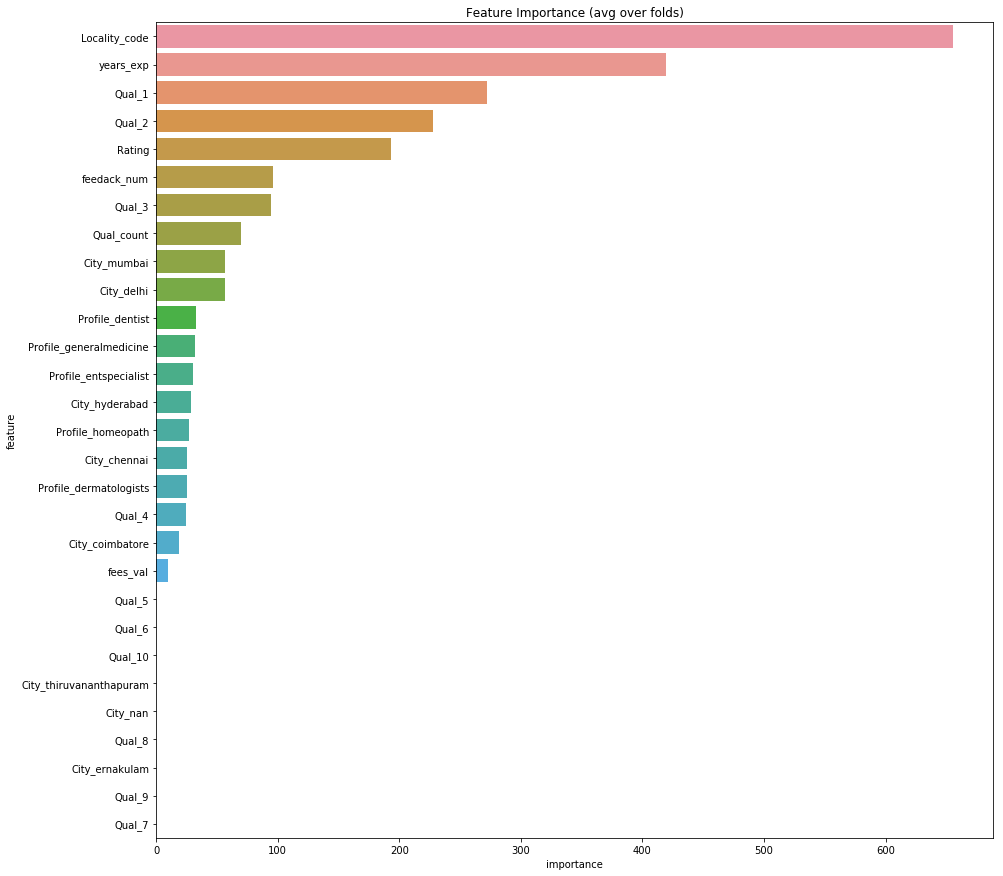

In [81]:
lgb_params = {
    'metric': 'rmse',
    "objective" : "regression",
    'min_data_in_leaf': 149, 
    'max_depth': 9,
    "boosting": "gbdt",
    "lambda_l1": 0.2634,
    "random_state": 133,
    "num_leaves" : 30,
    "min_child_samples" : 100,
    "learning_rate" : 0.1,
    "bagging_fraction" : 0.7,
    "feature_fraction" : 0.5,
    "bagging_frequency" : 5,
    "bagging_seed" : 4,
    "verbosity" : -1
    }

result_dict_lgb = train_model(X=train_X,
                              X_test=test_X,
                              y=train_y,
                              params=lgb_params,
                              model_type='lgb',
                              plot_feature_importance=True,
                              make_oof=True,
                              num_class=0                           
                             )

#### Capture LGB results.

In [82]:
test_lgb = test_df[['Qualification', 'Experience', 'Rating', 'Place', 'Profile','Miscellaneous_Info']].copy()
test_lgb['Fees'] = result_dict_lgb['prediction']


Fold 1 started at Fri Mar 29 08:03:27 2019
[0]	Validation-rmse:359.713
Will train until Validation-rmse hasn't improved in 100 rounds.
[100]	Validation-rmse:210.011
[200]	Validation-rmse:177.241
[300]	Validation-rmse:171.499
[400]	Validation-rmse:169.895
[500]	Validation-rmse:169.329
[600]	Validation-rmse:169.017
[700]	Validation-rmse:168.996
[800]	Validation-rmse:168.805
[900]	Validation-rmse:168.727
[1000]	Validation-rmse:168.645
[1100]	Validation-rmse:168.65
[1200]	Validation-rmse:168.541
[1300]	Validation-rmse:168.574
Stopping. Best iteration:
[1261]	Validation-rmse:168.522


Fold 2 started at Fri Mar 29 08:03:42 2019
[0]	Validation-rmse:355.069
Will train until Validation-rmse hasn't improved in 100 rounds.
[100]	Validation-rmse:203.389
[200]	Validation-rmse:170.764
[300]	Validation-rmse:165.032
[400]	Validation-rmse:163.795
[500]	Validation-rmse:163.189
[600]	Validation-rmse:162.958
[700]	Validation-rmse:162.651
[800]	Validation-rmse:162.521
[900]	Validation-rmse:162.357
Stoppin

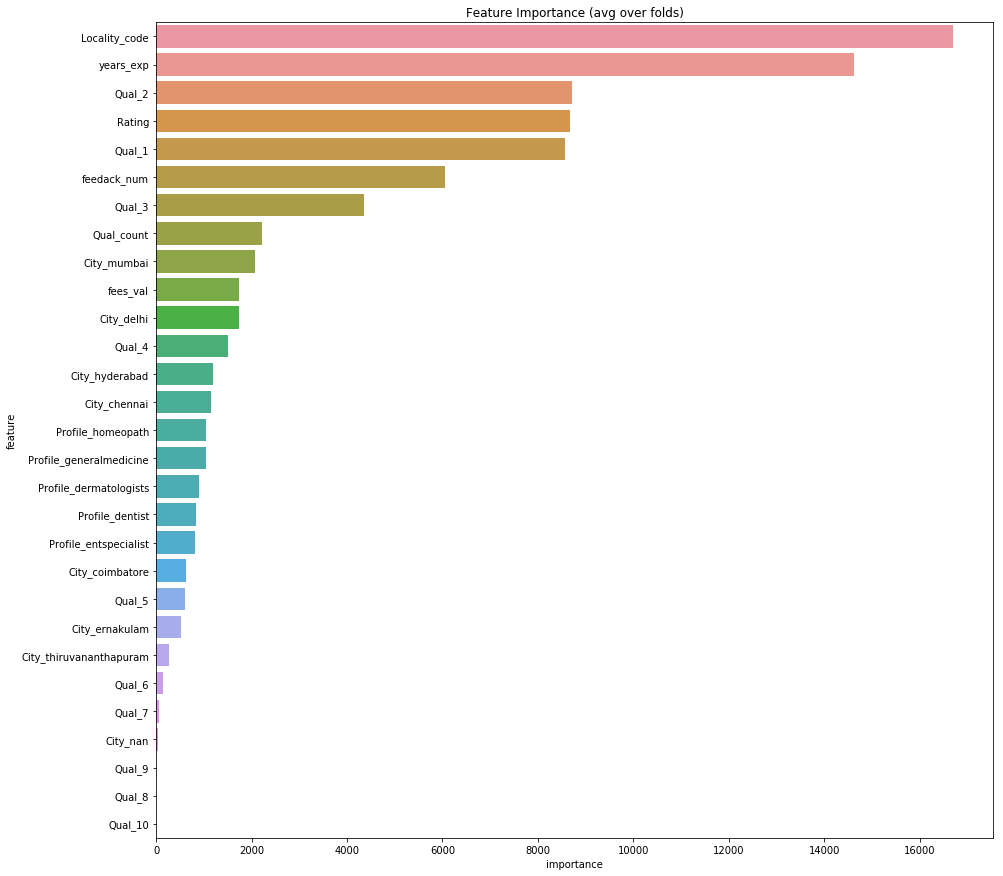

In [83]:
xgb_params = {
    "learning_rate" : 0.01,
    "n_estimators" : 3400,
    "max_depth" : 7,
    "min_child_weight" : 0,
    "gamma": 0,
    "subsample" : 0.7,
    "colsample_bytree" : 0.7,
    "objective" : 'reg:linear',
    "nthread" : -1,
    "scale_pos_weight" : 1,
    "seed" : 4,
    "reg_alpha" : 0.00006
}

result_dict_xgb = train_model(X=train_X,
                              X_test=test_X,
                              y=train_y,
                              params=xgb_params,
                              model_type='xgb',
                              plot_feature_importance=True,
                              make_oof=True,
                              num_class=0
                             )

#### Capture XGB Results

In [84]:
# Create XGB prediction

test_xgb = test_df[['Qualification', 'Experience', 'Rating', 'Place', 'Profile','Miscellaneous_Info']].copy()
test_xgb['Fees'] = result_dict_xgb['prediction']


Fold 1 started at Fri Mar 29 08:04:30 2019
0:	learn: 359.4742417	test: 360.1529683	best: 360.1529683 (0)	total: 62.2ms	remaining: 5m 11s
200:	learn: 177.9354184	test: 184.0005071	best: 184.0005071 (200)	total: 1.42s	remaining: 33.9s
400:	learn: 167.1359824	test: 174.9576224	best: 174.9576224 (400)	total: 2.87s	remaining: 33s
600:	learn: 164.2677822	test: 173.0800978	best: 173.0800978 (600)	total: 4.25s	remaining: 31.1s
800:	learn: 162.5659466	test: 172.2113787	best: 172.2113787 (800)	total: 5.61s	remaining: 29.4s
1000:	learn: 161.1436475	test: 171.5307352	best: 171.5307352 (1000)	total: 7s	remaining: 28s
1200:	learn: 159.8437447	test: 170.9794445	best: 170.9794445 (1200)	total: 8.4s	remaining: 26.6s
1400:	learn: 158.6932763	test: 170.6471397	best: 170.6471397 (1400)	total: 9.83s	remaining: 25.3s
1600:	learn: 157.7149076	test: 170.4583991	best: 170.4583991 (1600)	total: 11.2s	remaining: 23.9s
1800:	learn: 157.0473680	test: 170.3597570	best: 170.3597570 (1800)	total: 12.6s	remaining: 22

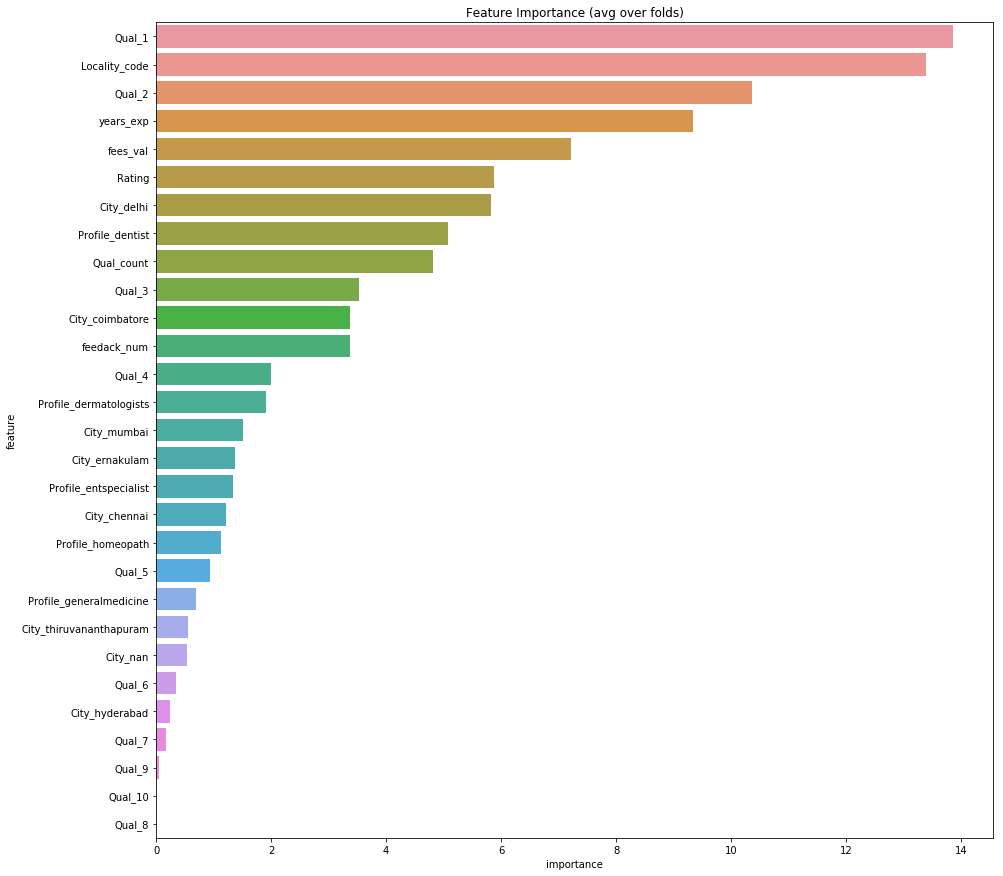

In [85]:
result_dict_cat = train_model(X=train_X,
                              X_test=test_X,
                              y=train_y,
                              model_type='cat',
                              plot_feature_importance=True,
                              make_oof=True,
                              num_class=0                           
                             )

#### Capture CAT Predictions

In [86]:
# Create CAT prediction

test_cat = test_df[['Qualification', 'Experience', 'Rating', 'Place', 'Profile','Miscellaneous_Info']].copy()
test_cat['Fees'] = result_dict_cat['prediction']

#### ANN for Regression

In [87]:
# Create X and Y dataset

Y = train_y.copy()
X = train[cols_to_use]

In [88]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.optimizers import Adam

# Function to create model
def baseline_model(learn_rate=0.01, init_mode='normal', activation = 'relu', dropout_rate=0.1, weight_constraint=1, neurons = 100):
    model = Sequential()
    model.add(Dense(units = neurons, kernel_initializer = init_mode, activation = activation, input_dim = 29))
    model.add(BatchNormalization())
#     model.add(Dropout(rate = dropout_rate))
    model.add(Dense(units = int(neurons / 2), kernel_initializer = init_mode, activation = activation))
#     model.add(Dropout(rate = dropout_rate))
    model.add(Dense(units = int(neurons / 4), kernel_initializer = init_mode, activation = activation))
#     model.add(Dropout(rate = dropout_rate))
    model.add(Dense(units = 1, kernel_initializer = init_mode, activation = 'linear'))
    optimizer = Adam(lr=learn_rate)
    model.compile(optimizer = optimizer, loss = 'mean_squared_logarithmic_error', metrics = ['mse'])
    return model

# fix random seed for reproducibility
seed = 4
np.random.seed(seed)

Using TensorFlow backend.


In [89]:
from keras.callbacks import ModelCheckpoint

checkpoint_name = 'weights.best.hdf5' 
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
callbacks_list = [checkpoint]

# Train the model
model = baseline_model()
model.summary()
model.fit(X, Y, epochs=100, batch_size=58, validation_split = 0.2, callbacks=callbacks_list)

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               3000      
_________________________________________________________________
batch_normalization_1 (Batch (None, 100)               400       
_________________________________________________________________
dense_2 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_3 (Dense)              (None, 25)                1275      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 26        
Total params: 9,751
Trainable params: 9,551
Non-trainable params: 200
_________________________________________________________________
Instructions for updating:
Use tf.cast instead.
Train on 4768 samp

In [90]:
weights_file = checkpoint_name # choose the best checkpoint 
model.load_weights(weights_file) # load it
model.compile(loss='mean_absolute_error', optimizer=Adam(lr=0.01), metrics=['mean_absolute_error'])

In [91]:
# Predictions
pred_dnn = model.predict(test[cols_to_use])

In [92]:
# Create submission
test_dnn = test_df[['Qualification', 'Experience', 'Rating', 'Place', 'Profile','Miscellaneous_Info']].copy()
test_dnn['Fees'] = pred_dnn

In [93]:
# Create average of LGB, XGB and DNN

df_test = test_df[['Qualification', 'Experience', 'Rating', 'Place', 'Profile','Miscellaneous_Info']].copy()
df_test["Fees"] = (test_xgb["Fees"] + test_lgb["Fees"] + test_cat["Fees"] + test_dnn["Fees"])/4

#### Let's default mark the Fees value as **100** for the selected records as decided

In [94]:
test_lgb = mark_100(test_lgb.copy())
test_xgb = mark_100(test_xgb.copy())
test_cat = mark_100(test_cat.copy())
test_dnn = mark_100(test_dnn.copy())
df_test = mark_100(df_test.copy())

#### Create the output files for the result submission

In [95]:
test_lgb.to_csv('submission_lgb.csv', index=False)
test_xgb.to_csv('submission_xgb.csv', index=False)
test_cat.to_csv('submission_cat.csv', index=False)
test_dnn.to_csv('submission_dnn.csv', index=False)
df_test.to_csv('submission_average.csv', index=False)

# Please **UPVOTE** if this kernel helped you in anyway :)